# **Importing Libraries**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from skimage.feature import hog
from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, auc
from sklearn.model_selection import cross_val_score
import joblib
import warnings
import random
import cv2
from google.colab import files
from io import BytesIO
from PIL import Image
from sklearn.preprocessing import label_binarize
from itertools import cycle
warnings.filterwarnings('ignore')

# **Data Exploring**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ML Project/ckextended.csv')

In [5]:
df.head()

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


In [6]:
df['emotion'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [7]:
df.shape

(920, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  920 non-null    int64 
 1   pixels   920 non-null    object
 2   Usage    920 non-null    object
dtypes: int64(1), object(2)
memory usage: 21.7+ KB


# **Preprocessing**

In [9]:
df = df.drop(columns=['Usage'])

In [10]:
classes_to_remove = [0, 2, 4, 7]
df = df[~df['emotion'].isin(classes_to_remove)]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
X = np.array([np.fromstring(image, sep=' ') for image in df['pixels']])

In [12]:
y = df['emotion'].values

In [13]:
X

array([[ 49.,  35.,  30., ...,  19.,   5.,  16.],
       [  0.,   0.,   0., ...,  15.,  22.,  30.],
       [ 11.,   8.,   8., ...,  85.,  33.,  37.],
       ...,
       [ 47.,  54.,  56., ...,  43.,  47.,  49.],
       [ 64.,  55.,  80., ..., 169.,  72.,  82.],
       [ 58.,   1.,   6., ...,  65., 130., 133.]])

In [ ]:
y

array([6, 1, 6, 6, 6, 5, 1, 6, 6, 1, 6, 3, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 3, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 5, 6, 3, 6, 6, 6, 6, 3, 3, 6,
       3, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 5, 3, 6, 1, 6, 5, 3, 6, 6, 1, 6,
       1, 6, 6, 6, 6, 1, 6, 5, 6, 6, 3, 5, 6, 5, 6, 3, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 3, 6, 6, 6, 5, 6, 3, 6, 6, 6, 6, 6,
       6, 5, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 1, 6, 6, 6, 3,
       5, 1, 6, 5, 6, 5, 1, 6, 3, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6,
       3, 6, 3, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6,
       6, 6, 6, 6, 6, 3, 5, 6, 3, 6, 6, 6, 6, 6, 1, 6, 3, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 3, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 1, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 5, 3, 6, 6, 5,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 1, 6, 6, 1, 6, 6, 6, 6, 3, 6,
       6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6,

**Balancing the data**

In [14]:
target_classes = [1, 3, 5, 6]
disgust_indices = np.where(y == 1)[0]
target_count = len(disgust_indices)
balanced_indices = []

for class_id in target_classes:
    indices = np.where(y == class_id)[0]
    selected_indices = np.random.choice(indices, target_count, replace=False)
    balanced_indices.extend(selected_indices)

balanced_indices = np.array(balanced_indices)
np.random.shuffle(balanced_indices)
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

In [15]:
X_balanced

array([[ 85.,  85.,  89., ...,  78.,  73.,  71.],
       [ 49.,  26.,   0., ...,  49.,  49.,  48.],
       [ 41.,  32.,  37., ...,  95., 101.,  90.],
       ...,
       [ 86.,  27.,   7., ..., 136., 124.,  86.],
       [114.,  87.,  16., ..., 255., 252., 247.],
       [255., 254., 255., ...,  69., 110., 142.]])

In [16]:
y_balanced

array([5, 1, 6, 5, 1, 6, 1, 6, 5, 6, 5, 3, 1, 3, 5, 5, 6, 6, 5, 6, 3, 3,
       3, 5, 3, 3, 1, 5, 5, 5, 5, 5, 6, 3, 3, 1, 6, 6, 6, 3, 5, 3, 6, 5,
       1, 5, 5, 1, 3, 5, 5, 5, 6, 3, 1, 6, 1, 1, 6, 6, 6, 6, 5, 3, 5, 1,
       1, 3, 5, 6, 3, 6, 5, 3, 1, 6, 3, 6, 6, 1, 5, 6, 5, 6, 6, 3, 3, 1,
       1, 5, 1, 3, 6, 3, 5, 6, 3, 5, 1, 6, 1, 1, 5, 1, 3, 1, 1, 6, 5, 5,
       1, 3, 5, 3, 5, 6, 6, 3, 5, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 5, 6,
       5, 5, 1, 6, 6, 1, 3, 3, 5, 1, 3, 3, 6, 1, 5, 3, 1, 1, 3, 1, 1, 5,
       1, 6, 5, 3, 6, 6, 1, 3, 6, 5, 3, 6, 1, 5, 5, 3, 6, 6, 3, 1, 6, 1,
       1, 3, 1, 3, 5, 1, 6, 3, 1, 5, 5, 5, 6, 1, 3, 6, 5, 5, 1, 5, 1, 6,
       5, 3, 6, 3, 6, 6, 3, 1, 5, 6, 6, 5, 5, 3, 6, 5, 1, 1, 5, 3, 1, 3,
       1, 1, 3, 6, 6, 6, 1, 1, 3, 3, 6, 6, 1, 3, 5, 3])

In [17]:
X_balanced.shape

(236, 2304)

In [18]:
y_balanced.shape

(236,)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

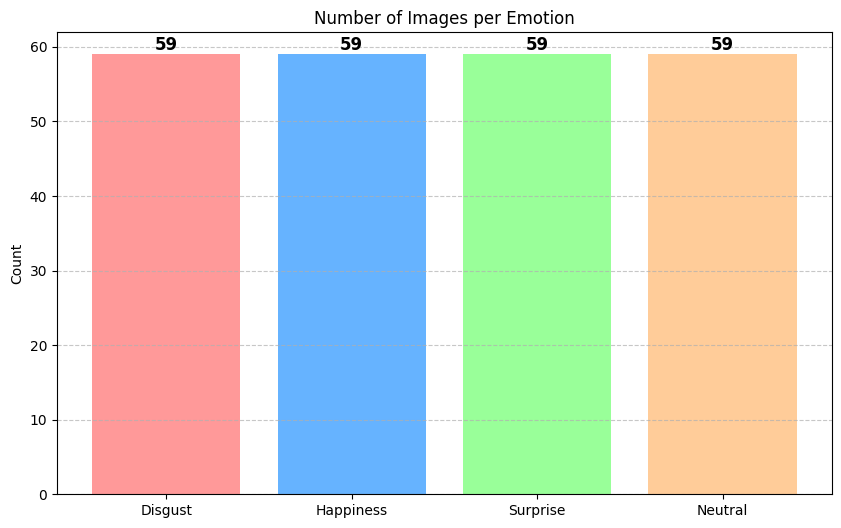

In [20]:
EMOTION_MAP = {1: 'Disgust', 3: 'Happiness', 5: 'Surprise', 6: 'Neutral'}

y_series = pd.Series(y_balanced)
counts = y_series.value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar([EMOTION_MAP[i] for i in counts.index], counts.values, color=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Number of Images per Emotion")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Data samples**

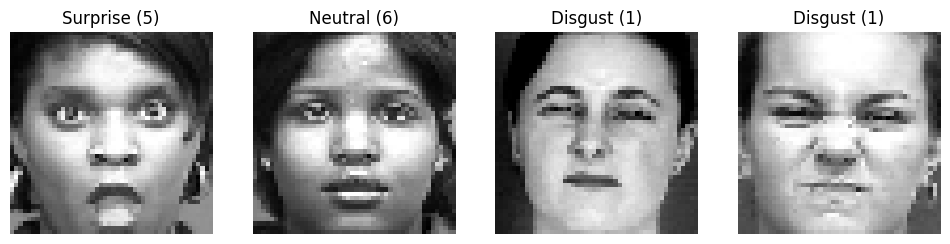

In [21]:
EMOTION_MAP = {
    1: 'Disgust',
    3: 'Happiness',
    5: 'Surprise',
    6: 'Neutral'
}

plt.figure(figsize=(12, 4))
for i in range(4):

    idx = random.randint(0, len(X_train) - 1)

    image_2d = X_train[idx].reshape(48, 48)

    label_index = y_train[idx]
    emotion_name = EMOTION_MAP[label_index]

    plt.subplot(1, 4, i+1)
    plt.imshow(image_2d, cmap='gray')
    plt.title(f"{emotion_name} ({label_index})")
    plt.axis('off')
plt.show()

# **Scaling**

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Model Training (LogisticRegression)**

**Making grid search to find the best parametrs**

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    solver='saga',
    max_iter=2000,
    n_jobs=-1,
    multi_class='multinomial',
    random_state=42
)

param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100]
    },

    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.2, 0.5, 0.8]
    }
]

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    return_train_score=True
)

In [ ]:
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
print(f"Best Params: {grid_search.best_params_}")
print(f"Best Cross-Val Accuracy: {grid_search.best_score_:.4f}")

In [23]:
logreg = LogisticRegression(
    solver='saga',
    max_iter=2000,
    n_jobs=-1,
    multi_class='multinomial',
    random_state=42,
    C = 1,
    l1_ratio = 0.2,
    penalty = 'elasticnet'
)
logreg.fit(X_train_scaled , y_train)

LogisticRegression(C=1, l1_ratio=0.2, max_iter=2000, multi_class='multinomial',
                   n_jobs=-1, penalty='elasticnet', random_state=42,
                   solver='saga')

In [33]:
import joblib

model_filename = 'emotion_recognition_model.pkl'
joblib.dump(logreg, model_filename)

['emotion_recognition_model.pkl']

**Training with the best parametrs**

Final Test Set Accuracy: 0.9792

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7
           3       1.00      1.00      1.00        16
           5       1.00      0.91      0.95        11
           6       0.93      1.00      0.97        14

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



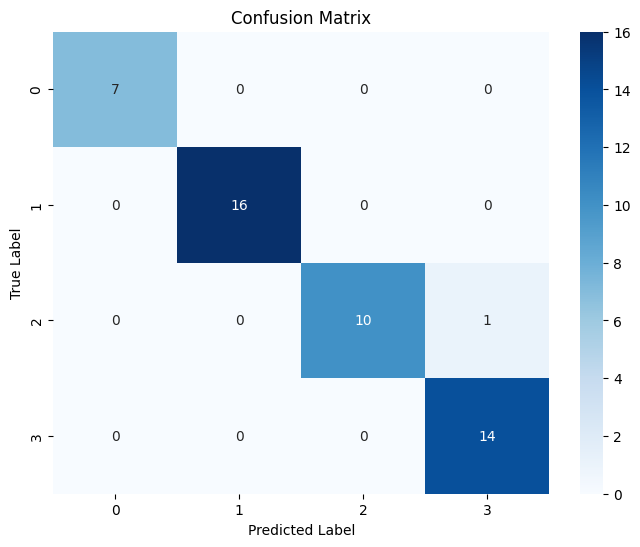

In [24]:
y_pred = logreg.predict(X_test_scaled)

final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Set Accuracy: {final_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"Scores for each fold: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Training and tracking loss...


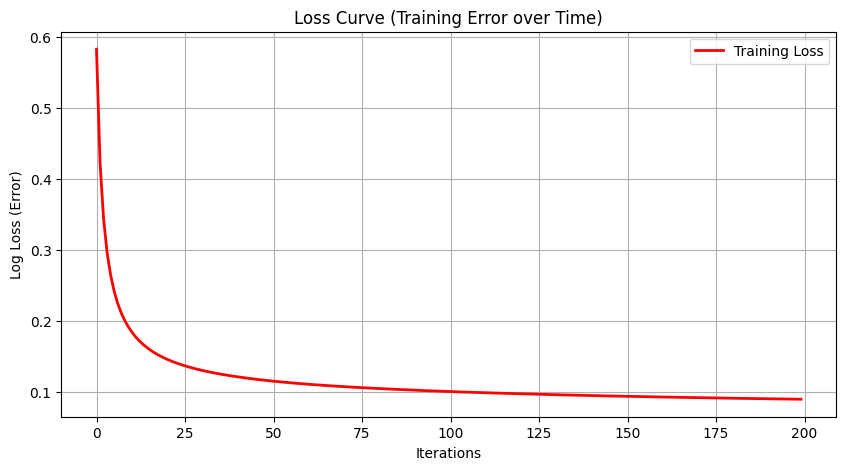

In [43]:
logreg_monitor = LogisticRegression(
    solver='saga',
    max_iter=1,
    warm_start=True,
    n_jobs=-1,
    multi_class='multinomial',
    random_state=42,
    C=1,
    l1_ratio=0.2,
    penalty='elasticnet'
)

loss_history = []
accuracy_history = []

print("Training and tracking loss...")
for i in range(200):
    logreg_monitor.fit(X_train_scaled, y_train)

    y_pred_proba = logreg_monitor.predict_proba(X_train_scaled)
    loss = log_loss(y_train, y_pred_proba)
    loss_history.append(loss)

    score = logreg_monitor.score(X_train_scaled, y_train)
    accuracy_history.append(score)

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss', color='red', linewidth=2)
plt.title('Loss Curve (Training Error over Time)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss (Error)')
plt.grid(True)
plt.legend()
plt.show()

# **Model Training (Kmeans)**



# **HOG**

In [36]:
def extract_hog_features(X_data):
    hog_features = []
    for i in range(len(X_data)):
        image = X_data[i].reshape(48, 48)

        features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

X_hog = extract_hog_features(X_balanced)

print(f"HOG Shape: {X_hog.shape}")

HOG Shape: (236, 900)


**Model fitting**

In [37]:
kmeans = KMeans(n_clusters=8, init='k-means++', n_init=50, max_iter=1000, random_state=42)
raw_clusters = kmeans.fit_predict(X_hog)

map_dictionary = {}
final_predictions = np.zeros_like(raw_clusters)

for i in range(8):
    mask = (raw_clusters == i)
    if np.sum(mask) > 0:
        most_common_emotion = mode(y_balanced[mask], keepdims=True)[0][0]
        map_dictionary[i] = most_common_emotion

        final_predictions[mask] = most_common_emotion

acc = accuracy_score(y_balanced, final_predictions)
print(f"Final Accuracy: {acc:.2%}")

Final Accuracy: 71.19%


**(TSNE) to make the data shape able to be plotted**

In [38]:
centroids_hog = kmeans.cluster_centers_

combined_data = np.vstack([X_hog, centroids_hog])

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
combined_2d = tsne.fit_transform(combined_data)

X_2d = combined_2d[:len(X_hog)]
centroids_2d = combined_2d[len(X_hog):]

**Scatter plot with (centroids)**

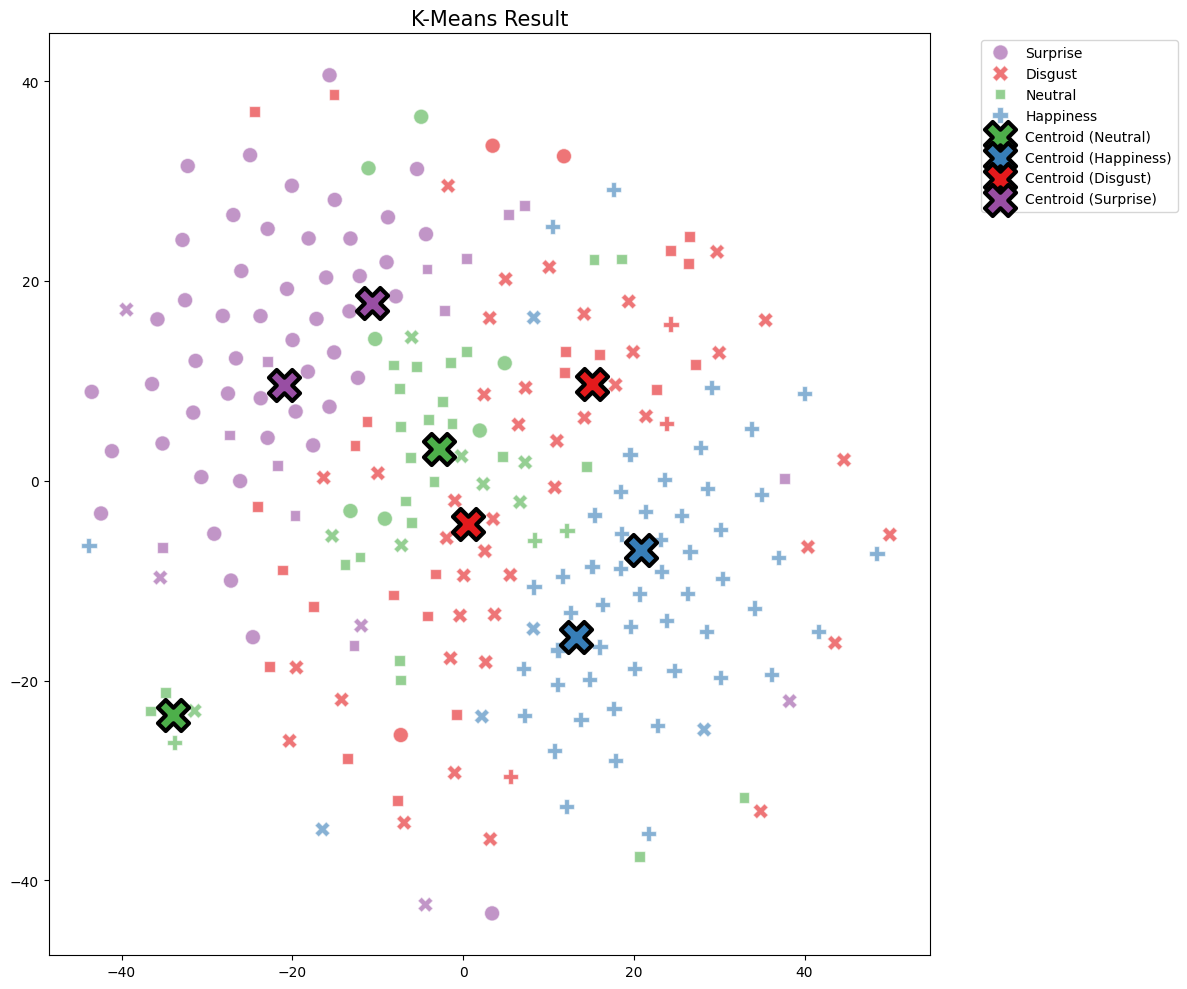

In [39]:
label_names = {
    1: 'Disgust',
    3: 'Happiness',
    5: 'Surprise',
    6: 'Neutral'
}

pred_labels = [label_names.get(x, x) for x in final_predictions]
true_labels = [label_names.get(x, x) for x in y_balanced]

unique_classes = sorted(list(label_names.values()))
palette = sns.color_palette('Set1', n_colors=len(unique_classes))
color_map = dict(zip(unique_classes, palette))

plt.figure(figsize=(12, 10))

sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=pred_labels,
    style=true_labels,
    palette=color_map,
    s=120,
    alpha=0.6
)


seen_labels = set()
for i in range(len(centroids_2d)):
    class_label = label_names[map_dictionary[i]]
    c = color_map[class_label]

    if class_label not in seen_labels:
        legend_label = f'Centroid ({class_label})'
        seen_labels.add(class_label)
    else:
        legend_label = None

    plt.scatter(
        centroids_2d[i, 0],
        centroids_2d[i, 1],
        color=c,
        marker='X',
        s=500,
        edgecolor='black',
        linewidth=3,
        label=legend_label
    )

plt.title(f'K-Means Result', fontsize=15)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Please upload a face image for testing...


Saving S026_006_00000011.png to S026_006_00000011 (1).png


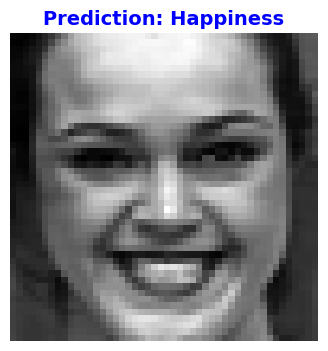

In [44]:


EMOTION_MAP = {
    1: 'Disgust',
    3: 'Happiness',
    5: 'Surprise',
    6: 'Neutral'
}

IMG_SIZE = (48, 48)

def predict_uploaded_image():
    print("Please upload a face image for testing...")
    uploaded = files.upload()

    for fn in uploaded.keys():
        img_data = uploaded[fn]
        image = Image.open(BytesIO(img_data)).convert('L')

        img_resized = image.resize(IMG_SIZE)

        img_array = np.array(img_resized)
        img_flat = img_array.flatten().reshape(1, -1)

        img_scaled = scaler.transform(img_flat)

        prediction = logreg.predict(img_scaled)[0]
        label = EMOTION_MAP.get(prediction, f"Unknown ({prediction})")

        plt.figure(figsize=(4, 4))
        plt.imshow(img_array, cmap='gray')
        plt.title(f"Prediction: {label}", fontsize=14, color='blue', fontweight='bold')
        plt.axis('off')
        plt.show()

predict_uploaded_image()